#### Monday, November 27, 2023

[LangChain Data Loaders, Tokenizers, Chunking, and Datasets - Data Prep 101](https://www.youtube.com/watch?v=eqOfr4AGLk8&list=PLIUOU7oqGTLieV9uTIFMm6_4PXg-hlN6F&index=4)

This notebook does not use OpenAI.

Hmm [tiktoken](https://github.com/openai/tiktoken) is an open source BPE tokeniser for use with OpenAI's models.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/pinecone-io/examples/blob/master/learn/generation/langchain/handbook/xx-langchain-chunking.ipynb) [![Open nbviewer](https://raw.githubusercontent.com/pinecone-io/examples/master/assets/nbviewer-shield.svg)](https://nbviewer.org/github/pinecone-io/examples/blob/master/learn/generation/langchain/handbook/xx-langchain-chunking.ipynb)

#### [LangChain Handbook](https://pinecone.io/learn/langchain)

# Preparing Text Data for use with Retrieval-Augmented LLMs

In this walkthrough we'll take a look at an example and some of the considerations when we need to prepare text data for retrieval augmented question-answering using **L**arge **L**anguage **M**odels (LLMs).

## Required Libraries

There are a few Python libraries we must `pip install` for this notebook to run, those are:

In [1]:
# !pip install -qU langchain tiktoken matplotlib seaborn tqdm

## Preparing Data

In this example, we will download the LangChain docs from [langchain.readthedocs.io/](https://langchain.readthedocs.io/latest/en/). We get all `.html` files located on the site like so:

In [3]:
# To get this to run, I had to run this ...
#  wget -r -A.html -P rtdocs https://api.python.langchain.com/en/latest/
# ... in an outside terminal window then manually move it into the desired folder of this repo ...
# And this downloads 158.4mb of data!

# This does not work ... cuz that url is now dead ...
# !wget -r -A.html -P rtdocs https://langchain.readthedocs.io/en/latest/

/bin/bash: wget: command not found
CPU times: user 531 µs, sys: 3.92 ms, total: 4.46 ms
Wall time: 484 ms


This downloads all HTML into the `rtdocs` directory. Now we can use LangChain itself to process these docs. We do this using the `ReadTheDocsLoader` like so:

In [4]:
from langchain.document_loaders import ReadTheDocsLoader

loader = ReadTheDocsLoader('rtdocs')
docs = loader.load()
len(docs)

3086

This leaves us with `3086` processed doc pages. Let's take a look at the format each one contains:

In [5]:
docs[0]

Document(page_content='langchain_core API Reference¶\nlangchain_core.agents¶\nClasses¶\nagents.AgentAction\nA full description of an action for an ActionAgent to execute.\nagents.AgentActionMessageLog\nOverride init to support instantiation by position for backward compat.\nagents.AgentFinish\nThe final return value of an ActionAgent.\nlangchain_core.caches¶\nClasses¶\ncaches.BaseCache()\nBase interface for cache.\nlangchain_core.callbacks¶\nClasses¶\ncallbacks.base.AsyncCallbackHandler()\nAsync callback handler that handles callbacks from LangChain.\ncallbacks.base.BaseCallbackHandler()\nBase callback handler that handles callbacks from LangChain.\ncallbacks.base.BaseCallbackManager(handlers)\nBase callback manager that handles callbacks from LangChain.\ncallbacks.base.CallbackManagerMixin()\nMixin for callback manager.\ncallbacks.base.ChainManagerMixin()\nMixin for chain callbacks.\ncallbacks.base.LLMManagerMixin()\nMixin for LLM callbacks.\ncallbacks.base.RetrieverManagerMixin()\nMi

We access the plaintext page content like so:

In [6]:
print(docs[0].page_content)

langchain_core API Reference¶
langchain_core.agents¶
Classes¶
agents.AgentAction
A full description of an action for an ActionAgent to execute.
agents.AgentActionMessageLog
Override init to support instantiation by position for backward compat.
agents.AgentFinish
The final return value of an ActionAgent.
langchain_core.caches¶
Classes¶
caches.BaseCache()
Base interface for cache.
langchain_core.callbacks¶
Classes¶
callbacks.base.AsyncCallbackHandler()
Async callback handler that handles callbacks from LangChain.
callbacks.base.BaseCallbackHandler()
Base callback handler that handles callbacks from LangChain.
callbacks.base.BaseCallbackManager(handlers)
Base callback manager that handles callbacks from LangChain.
callbacks.base.CallbackManagerMixin()
Mixin for callback manager.
callbacks.base.ChainManagerMixin()
Mixin for chain callbacks.
callbacks.base.LLMManagerMixin()
Mixin for LLM callbacks.
callbacks.base.RetrieverManagerMixin()
Mixin for Retriever callbacks.
callbacks.base.RunMana

In [7]:
print(docs[5].page_content)

langchain_core.language_models.llms.update_cache¶
langchain_core.language_models.llms.update_cache(existing_prompts: Dict[int, List], llm_string: str, missing_prompt_idxs: List[int], new_results: LLMResult, prompts: List[str]) → Optional[dict][source]¶
Update the cache and get the LLM output.


We can also find the source of each document:

In [8]:
docs[5].metadata['source'].replace('rtdocs/', 'https://')

'https://api.python.langchain.com/en/latest/language_models/langchain_core.language_models.llms.update_cache.html'

Looks good, we need to also consider the length of each page with respect to the number of tokens that will reasonably fit within the window of the latest LLMs. We will use `gpt-3.5-turbo` as an example.

To count the number of tokens that `gpt-3.5-turbo` will use for some text we need to initialize the `tiktoken` tokenizer.

In [9]:
import tiktoken

tokenizer = tiktoken.get_encoding('cl100k_base')

# create the length function
def tiktoken_len(text):
    tokens = tokenizer.encode(
        text,
        disallowed_special=()
    )
    return len(tokens)

Note that for the tokenizer we defined the encoder as `"cl100k_base"`. This is a specific tiktoken encoder which is used by `gpt-3.5-turbo`. Other encoders exist. At the time of writing the OpenAI specific tokenizers (using `tiktoken`) are summarized as:

| Encoder | Models |
| --- | --- |
| `cl100k_base` | `gpt-4`, `gpt-3.5-turbo`, `text-embedding-ada-002` |
| `p50k_base` | `text-davinci-003`, `code-davinci-002`, `code-cushman-002` |
| `r50k_base` | `text-davinci-001`, `davinci`, `text-similarity-davinci-001` |
| `gpt2` | `gpt2` |

You can find these details in the [Tiktoken `model.py` script](https://github.com/openai/tiktoken/blob/main/tiktoken/model.py), or using `tiktoken.encoding_for_model`:

In [10]:
tiktoken.encoding_for_model('gpt-3.5-turbo')

<Encoding 'cl100k_base'>

Using the `tiktoken_len` function, let's count and visualize the number of tokens across our webpages.

In [11]:
token_counts = [tiktoken_len(doc.page_content) for doc in docs]

Let's see `min`, average, and `max` values:

In [12]:
print(f"""Min: {min(token_counts)}
Avg: {int(sum(token_counts) / len(token_counts))}
Max: {max(token_counts)}""")

Min: 0
Avg: 1552
Max: 35097


Now visualize:

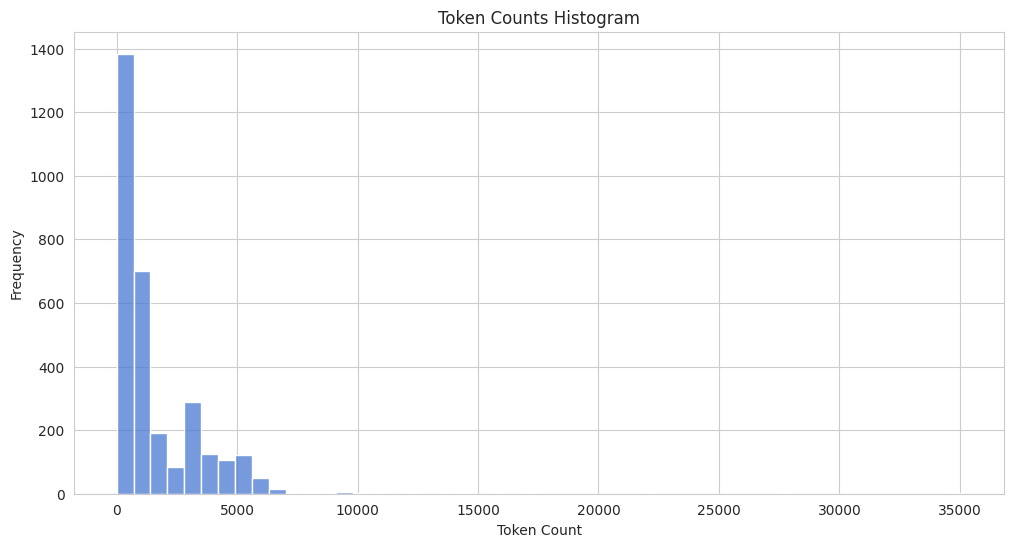

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# set style and color palette for the plot
sns.set_style("whitegrid")
sns.set_palette("muted")

# create histogram
plt.figure(figsize=(12, 6))
sns.histplot(token_counts, kde=False, bins=50)

# customize the plot info
plt.title("Token Counts Histogram")
plt.xlabel("Token Count")
plt.ylabel("Frequency")

plt.show()

The vast majority of pages seem to contain a lower number of tokens. But our limits for the number of tokens to add to each chunk is actually smaller than some of the smaller pages. But, how do we decide what this number should be?

### Chunking the Text

At the time of writing, `gpt-3.5-turbo` supports a context window of 4096 tokens — that means that input tokens + generated ( / completion) output tokens, cannot total more than 4096 without hitting an error.

So we 100% need to keep below this. If we assume a very safe margin of ~2000 tokens for the input prompt into `gpt-3.5-turbo`, leaving ~2000 tokens for conversation history and completion.

With this ~2000 token limit we may want to include *five* snippets of relevant information, meaning each snippet can be no more than **400** token long.

To create these snippets we use the `RecursiveCharacterTextSplitter` from LangChain. To measure the length of snippets we also need a *length function*. This is a function that consumes text, counts the number of tokens within the text (after tokenization using the `gpt-3.5-turbo` tokenizer), and returns that number. We define it like so:

With the length function defined we can initialize our `RecursiveCharacterTextSplitter` object like so:

In [14]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=400,
    chunk_overlap=20,  # number of tokens overlap between chunks
    length_function=tiktoken_len,
    separators=['\n\n', '\n', ' ', '']
)

Then we split the text for a document like so:

In [17]:
# chunks = text_splitter.split_text(docs[5].page_content) ... page 5 has issue, so ...
chunks = text_splitter.split_text(docs[0].page_content)
len(chunks)

15

In [18]:
tiktoken_len(chunks[0]), tiktoken_len(chunks[1])

(359, 363)

For `docs[5]` we created `2` chunks of token length `346` and `247`.

This is for a single document, we need to do this over all of our documents. While we iterate through the docs to create these chunks we will reformat them into a format that looks like:

```json
[
    {
        "id": "abc-0",
        "text": "some important document text",
        "source": "https://langchain.readthedocs.io/en/latest/glossary.html"
    },
    {
        "id": "abc-1",
        "text": "the next chunk of important document text",
        "source": "https://langchain.readthedocs.io/en/latest/glossary.html"
    }
    ...
]
```

The `"id"` will be created based on the URL of the text + it's chunk number.

In [19]:
import hashlib
m = hashlib.md5()  # this will convert URL into unique ID

# url = docs[5].metadata['source'].replace('rtdocs/', 'https://')
url = docs[0].metadata['source'].replace('rtdocs/', 'https://')
print(url)

# convert URL to unique ID
m.update(url.encode('utf-8'))
uid = m.hexdigest()[:12]
print(uid)

https://api.python.langchain.com/en/latest/core_api_reference.html
894c068cfc85


Then use the `uid` alongside chunk number and actual `url` to create the format needed:

In [20]:
data = [
    {
        'id': f'{uid}-{i}',
        'text': chunk,
        'source': url
    } for i, chunk in enumerate(chunks)
]
data

[{'id': '894c068cfc85-0',
  'text': 'langchain_core API Reference¶\nlangchain_core.agents¶\nClasses¶\nagents.AgentAction\nA full description of an action for an ActionAgent to execute.\nagents.AgentActionMessageLog\nOverride init to support instantiation by position for backward compat.\nagents.AgentFinish\nThe final return value of an ActionAgent.\nlangchain_core.caches¶\nClasses¶\ncaches.BaseCache()\nBase interface for cache.\nlangchain_core.callbacks¶\nClasses¶\ncallbacks.base.AsyncCallbackHandler()\nAsync callback handler that handles callbacks from LangChain.\ncallbacks.base.BaseCallbackHandler()\nBase callback handler that handles callbacks from LangChain.\ncallbacks.base.BaseCallbackManager(handlers)\nBase callback manager that handles callbacks from LangChain.\ncallbacks.base.CallbackManagerMixin()\nMixin for callback manager.\ncallbacks.base.ChainManagerMixin()\nMixin for chain callbacks.\ncallbacks.base.LLMManagerMixin()\nMixin for LLM callbacks.\ncallbacks.base.RetrieverMana

Now we repeat the same logic across our full dataset:

In [21]:
from tqdm.auto import tqdm

documents = []

for doc in tqdm(docs):
    url = doc.metadata['source'].replace('rtdocs/', 'https://')
    m.update(url.encode('utf-8'))
    uid = m.hexdigest()[:12]
    chunks = text_splitter.split_text(doc.page_content)
    for i, chunk in enumerate(chunks):
        documents.append({
            'id': f'{uid}-{i}',
            'text': chunk,
            'source': url
        })

len(documents)

  0%|          | 0/3086 [00:00<?, ?it/s]

15019

We're now left with `15019` documents. We can save them to a JSON lines (`.jsonl`) file like so:

In [22]:
import json

with open('train.jsonl', 'w') as f:
    for doc in documents:
        f.write(json.dumps(doc) + '\n')

To load the data from file we'd write:

In [23]:
documents = []

with open('train.jsonl', 'r') as f:
    for line in f:
        documents.append(json.loads(line))

len(documents)

15019

In [24]:
documents[0]

{'id': 'f160502deb25-0',
 'text': 'langchain_core API Reference¶\nlangchain_core.agents¶\nClasses¶\nagents.AgentAction\nA full description of an action for an ActionAgent to execute.\nagents.AgentActionMessageLog\nOverride init to support instantiation by position for backward compat.\nagents.AgentFinish\nThe final return value of an ActionAgent.\nlangchain_core.caches¶\nClasses¶\ncaches.BaseCache()\nBase interface for cache.\nlangchain_core.callbacks¶\nClasses¶\ncallbacks.base.AsyncCallbackHandler()\nAsync callback handler that handles callbacks from LangChain.\ncallbacks.base.BaseCallbackHandler()\nBase callback handler that handles callbacks from LangChain.\ncallbacks.base.BaseCallbackManager(handlers)\nBase callback manager that handles callbacks from LangChain.\ncallbacks.base.CallbackManagerMixin()\nMixin for callback manager.\ncallbacks.base.ChainManagerMixin()\nMixin for chain callbacks.\ncallbacks.base.LLMManagerMixin()\nMixin for LLM callbacks.\ncallbacks.base.RetrieverManage

### (Optional) Sharing the Dataset

We've now created our dataset and you can go ahead and use it in any way you like. However, if you'd like to share the dataset, or store it somewhere that you can get easy access to later — we can use [Hugging Face Datasets Hub](https://huggingface.co/datasets).

To begin we first need to create an account by clicking the **Sign Up** button at [huggingface.co](https://huggingface.co/). Once done we click our profile button in the same location > click **New Dataset** > give it a name like *"langchain-docs"* > set the dataset to **Public** or **Private** > click **Create dataset**.